In [ ]:
import os
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [3]:
# load pre-trained model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 62)

model_path = "medium_models/resnet_finetuned_bs32_1epoch.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

model = model.to(device)

model.eval()

/var/folders/d5/5853p9zd6pvbjb8vz92bhmnc0000gn/T/ipykernel_32351/3915051973.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
def generate_gradcam(input_tensor, class_idx=None):
    model.eval()
    # Forward
    scores = model(input_tensor)  # shape (1, num_classes)
    if class_idx is None:
        class_idx = scores.argmax(dim=1).item()

    # Zero grads, backward on the target score
    model.zero_grad()
    score = scores[0, class_idx]
    score.backward()

    # Compute weights: global-average-pool the gradients
    weights = gradients.mean(dim=(2,3), keepdim=True)  # shape (1, C, 1, 1)

    # Weighted sum of activations
    cam = (weights * activations).sum(dim=1, keepdim=True)  # shape (1,1,H',W')
    cam = F.relu(cam)

    # Upsample to input size
    cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()
    # Normalize
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

In [9]:
def show_gradcam_on_image(img_pil, cam):
    img_np = np.array(img_pil) / 255.0  # normalize for visualization
    heatmap = plt.cm.jet(cam)[...,:3]   # apply colormap
    overlay = 0.4*heatmap + 0.6*img_np
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

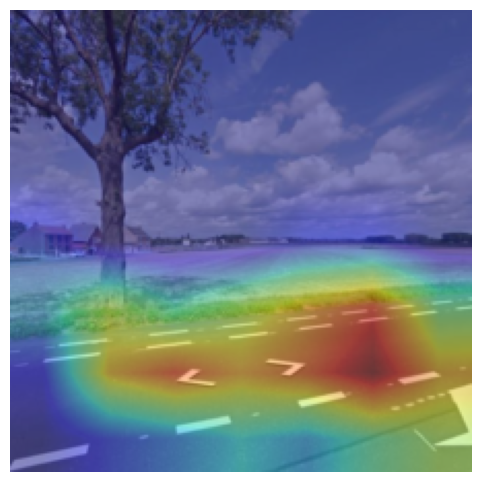

In [33]:
# 1) Choose the target convolutional layer
target_layer = model.layer4

# 2) Containers for forward activations and backward gradients
activations, gradients = None, None

# 3) Forward hook to grab activations
def forward_hook(module, inp, outp):
    global activations
    activations = outp.detach()

# 4) Backward hook to grab gradients
def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()

# 5) Register hooks
handle_f = target_layer.register_forward_hook(forward_hook)
handle_b = target_layer.register_backward_hook(backward_hook)

# Preprocess
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
img_pil = Image.open("medium_dataset/Belgium/234.jpg").convert("RGB")
input_tensor = transform(img_pil).unsqueeze(0).to(device)

# resize img_pil to (224,224,3)
img_pil = img_pil.resize((224, 224), Image.BILINEAR)

# Generate CAM and visualize
cam = generate_gradcam(input_tensor)
show_gradcam_on_image(img_pil, cam)

# Clean up hooks when done
handle_f.remove()
handle_b.remove()

## More insights

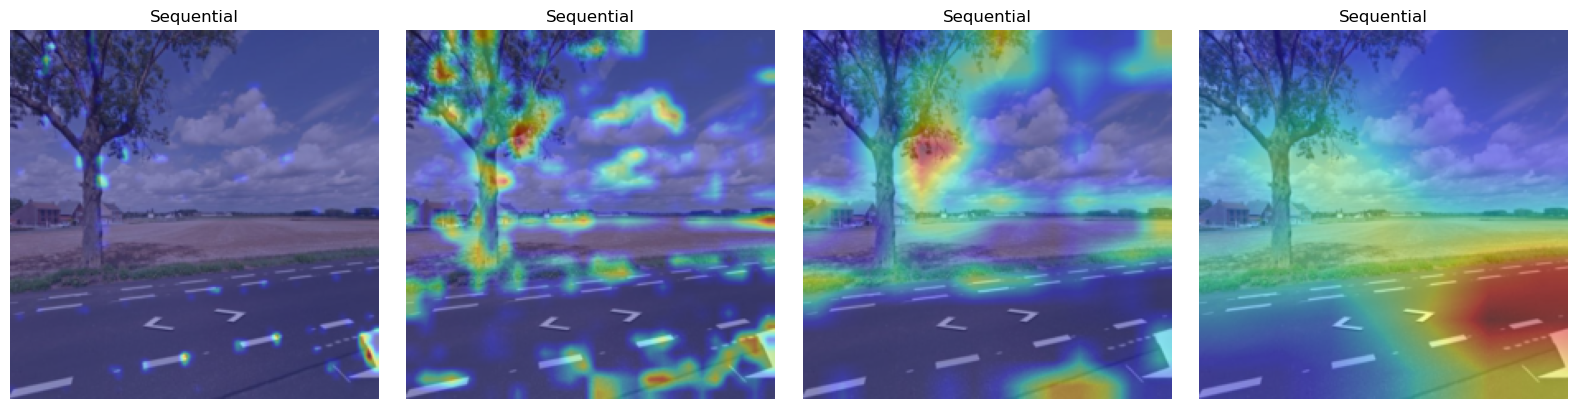

In [49]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 1) Load pretrained model and set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = models.resnet50(pretrained=True).to(device).eval()

# 2) Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# 3) Helper: get activations & gradients from a layer
def get_gradcam_fn(layer):
    activations, gradients = {}, {}
    def forward_hook(m, i, o):
        activations['val'] = o.detach()
    def backward_hook(m, gi, go):
        gradients['val'] = go[0].detach()
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    return activations, gradients

# 4) Grad-CAM generator
def gradcam(activations, gradients, class_idx, img_size):
    weights = gradients.mean(dim=[2,3], keepdim=True)
    cam = F.relu((weights * activations).sum(dim=1, keepdim=True))
    cam = F.interpolate(cam, img_size, mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min())/(cam.max()-cam.min()+1e-8)
    return cam

# 5) Load & preprocess a single image
img_pil = Image.open("medium_dataset/Belgium/234.jpg").convert("RGB")
input_tensor = preprocess(img_pil).unsqueeze(0).to(device)

# 6) Choose layers to visualize
layers = [model.layer1, model.layer2, model.layer3, model.layer4]
fig, axes = plt.subplots(1, len(layers), figsize=(16,4))
axes = axes.flatten()

for ax, layer in zip(axes, layers):
    acts, grads = get_gradcam_fn(layer)
    # forward + backward for predicted class
    scores = model(input_tensor)
    pred = scores.argmax(dim=1).item()
    model.zero_grad(); scores[0,pred].backward()
    cam = gradcam(acts['val'], grads['val'], pred, input_tensor.shape[2:])
    heatmap = plt.cm.jet(cam)[..., :3]
    img_pil = img_pil.resize((224, 224), Image.BILINEAR)
    overlay = 0.4*heatmap + 0.6*np.array(img_pil)/255.0
    ax.imshow(overlay); ax.axis('off')
    ax.set_title(layer.__class__.__name__)

plt.tight_layout()
plt.show()


In [39]:
project_root   = Path().resolve()
medium_ds_root  = project_root / "medium_dataset"
COUNTRIES = sorted([d.name for d in medium_ds_root.iterdir() if d.is_dir()])

In [40]:
class CountryImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for idx, country in enumerate(COUNTRIES):
            country_dir = root_dir / country
            for img_file in country_dir.iterdir():
                if img_file.suffix.lower() in (".jpg", ".jpeg", ".png"):
                    self.samples.append((img_file, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        path, label = self.samples[i]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [41]:
# Transforms: resize + normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [43]:
dataset = CountryImageDataset(medium_ds_root, transform=transform)
labels = [label for _, label in dataset.samples]  
# samples holds (path,label) pairs in order

# 2) Stratified split indices (80% train, 20% test)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X=[0]*len(labels), y=labels))

# 3) Create PyTorch subset datasets
train_ds = Subset(dataset, train_idx)
test_ds  = Subset(dataset, test_idx)

In [54]:
len(test_ds.indices)

7110